In [18]:
#################################################################
#####      Auteurs : A. Benki, R.Reynier et C. Corbin       #####
#################################################################


"""
Ce script nous permet de faire une comparaison entre les algorithmes :
Machine learning ( KNN, SVM et RF) --->  ( les meilleurs paramètres obtenus par Validation Croisée )
VS
Deep learning ( RN dense) --->  ( Choix de nombre de couche et les paramètres faites par intuition )


Cas D'étude 3 : Base de données réduite ( clustering par région / region A)
Traitement : Remplacement des Nans par les moyennes saisonnières  + drop pour le reste des nans de 
             deux variables ( RainToday et RainTomorow)
"""


print ("-----------------------------------------------------------------------------")
print ("-----------------------Import des packages  ...------------------------------")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
sns.set_theme()

from sklearn import model_selection
from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors, metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import VotingClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score



print ("-----------------------------------------------------------------------------")
print ("--------------------------lire la data --------------------------------------")

df=pd.read_csv("../data/weatherAUS_KCode_fillna.csv",index_col="Unnamed: 0")
df=df.dropna()
df=df.drop('KCode',1)
print(df.isna().sum())
print(df.shape)

df= df[df["KC"] == "A"]

print ("-----------------------------------------------------------------------------")
print ("# --------- (traitement Var catégorielles ----> quantitatives) -------------#")

# Traitement colonne date , transformation en 3 colonne jr , mois et année
##########################################################################

df['Date'] = pd.DataFrame(pd.to_datetime(df['Date']))
df.insert(0, "Year", df['Date'].dt.year, allow_duplicates=False)
df.insert(0, "Month", df['Date'].dt.month, allow_duplicates=False)
df.insert(0, "Day", df['Date'].dt.day, allow_duplicates=False)

df = df.drop("Date",1)

# Traitement colonne location ,  affecter à chaque location une valeur numérique
###############################################################################""


hh = df['Location'].value_counts()
hh_df= pd.DataFrame(hh)

for k in range(hh_df.shape[0]) :
    df['Location']=df['Location'].replace(hh_df.index[k],k+1)
    
    
# Traitement colonnes directions Vents location ,  affecter à chaque direction une valeur numérique
###############################################################################################""

#vent = df['WindGustDir'].value_counts()

V_D=['E','N','S','W', 'NE' , 'NW' , 'SE'  , 'SW'  ,'ENE', 'ESE', 'NNE', 'NNW','SSE','SSW','WNW','WSW']
V_D_Num=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]

df['WindGustDir'] = df['WindGustDir'].replace(V_D,V_D_Num)
df['WindDir9am'] = df['WindDir9am'].replace(V_D,V_D_Num)
df['WindDir3pm'] = df['WindDir3pm'].replace(V_D,V_D_Num)


# Traitement colonnes Rain_Today , Rain_Tomorrow ,  affecter une valeur numérique (0 si nn, 1 si oui)
####################################################################################################

#pluie = df['RainToday'].value_counts()

Rain_N_Y=['No','Yes']
Rain_N_Y_Num=[0,1]

df['RainToday'] = df['RainToday'].replace(Rain_N_Y,Rain_N_Y_Num)
df['RainTomorrow'] = df['RainTomorrow'].replace(Rain_N_Y,Rain_N_Y_Num)

# Traitement colonne code régions,  affecter une valeur numérique (1 si A, 2 si B et 3 si C)
####################################################################################################

#pluie = df['RainToday'].value_counts()

Region_C=['A','B','C']
Region_C_Num=[1,2,3]

df['KC'] = df['KC'].replace(Region_C,Region_C_Num)



print ("-----------------------------------------------------------------------------")
print ("# ---- (Verification no NANs et tous les valeurs sont Numériques) ----------#")

# Verification no NANs et tous les valeurs sont Numériques
#########################################################""
res_num_inter = df.select_dtypes(exclude='number')
print(res_num_inter.columns)
df.head()
df.isna().sum()


print ("-----------------------------------------------------------------------------")
print ("# ---- (Copier DataFrame & split (Train/Test) ) ----------#")

df_modelisation = df
df_modelisation.head()

df_X=df_modelisation.drop('RainTomorrow',1)
Target=df_modelisation['RainTomorrow']


# split 
#######

X_train, X_test, y_train, y_test = train_test_split(df_X, Target, test_size=0.2, random_state=42)

# Centrer et réduire les variables explicatives des deux échantillons de manière adéquate
# On applique  la fonction preprocessing.scale
#########################################################################################

X_train_scaled = preprocessing.scale(X_train)
X_test_scaled = preprocessing.scale(X_test)

# Gestion des problèmes de Classification déséquilibrée
#######################################################

# rUs = RandomUnderSampler()
# X_train_scaled, y_train = rUs.fit_resample(X_train_scaled, y_train)

# rOs = RandomOverSampler()
# X_train_scaled, y_train = rOs.fit_resample(X_train_scaled, y_train)


print ("-----------------------------------------------------------------------------")
print ("# --------- Machine Learning  -------------#")


# Dans la suite nous allons comparer plusieurs méthodes d'apprentissage. Pour chacune d'elles, 
# il conviendra d'explorer le périmètre des hyperparamètres suivant :

#-------------------------------------------------------------------------------------------------

#------------KNN ------------

# Les valeurs des hyperparamètres à tester
param_KNN = {'n_neighbors':range(2,21)}

# Création d'un classifieur kNN avec recherche d'hyperparamètre par validation croisée

clf_KNN = model_selection.GridSearchCV(
    neighbors.KNeighborsClassifier(), # un classifieur kNN
    param_KNN,                            # hyperparamètres à tester
    cv=5,                             # nombre de folds de validation croisée
    scoring='accuracy'                # score à optimiser (proportion de prédictions correctes)
)

# Optimiser ce classifieur sur le jeu d'entraînement
clf_KNN.fit(X_train_scaled, y_train)


# Afficher l'hyperparamètre optimal retenu
print('-------------------------------------------------- \n')
print("Meilleur hyperparamètre sur le jeu d'entraînement est :")
print(clf_KNN.best_params_)



# Appliquez le modèle à l'ensemble de test:

y_pred_KNN = clf_KNN.predict(X_test_scaled)

# matrice de confusion :

pd.crosstab(y_test, y_pred_KNN, rownames=['Classe réelle'], colnames=['Classe prédite'])


# le score du modèle :

print("le score du modèle KNN est : " , metrics.accuracy_score(y_test, y_pred_KNN))


#------------SVM ------------

# Les valeurs des hyperparamètres à tester

param_SVM = {'C':[0.1, 1], 'kernel':['linear', 'rbf']}


# Création d'un classifieur SVM avec recherche d'hyperparamètre par validation croisée

clf_SVM = model_selection.GridSearchCV(
    svm.SVC(),                        # classification par SVM
    param_SVM,                        # hyperparamètres à tester
    cv=5,                             # nombre de folds de validation croisée
    scoring='accuracy'                # score à optimiser (proportion de prédictions correctes)
)

# Optimiser ce classifieur sur le jeu d'entraînement
clf_SVM.fit(X_train_scaled, y_train)


# Afficher les hyperparamètres optimaux retenus
print('-------------------------------------------------- \n')
print("Meilleurs hyperparamètres sur le jeu d'entraînement sont :")
print(clf_SVM.best_params_)

# Appliquez le modèle à l'ensemble de test:

y_pred_SVM = clf_SVM.predict(X_test_scaled)

# matrice de confusion :

pd.crosstab(y_test, y_pred_SVM, rownames=['Classe réelle'], colnames=['Classe prédite'])

# le score du modèle :

print("le score du modèle SVM est : " , metrics.accuracy_score(y_test, y_pred_SVM))


#-------------------------------------------------------------------------------------------------

#------------Random Forest ------------

# Les valeurs des hyperparamètres à tester

param_RF= {'max_features': ["sqrt", "log2"], 'min_samples_split': range(2, 11,2)}


# Création d'un classifieur RF avec recherche d'hyperparamètre par validation croisée

clf_RF = model_selection.GridSearchCV(
    ensemble.RandomForestClassifier(),   # classification par RF
    param_RF,                           # hyperparamètres à tester
    cv=5,                                # nombre de folds de validation croisée
    scoring='accuracy'                   # score à optimiser (proportion de prédictions correctes)
)

# Optimiser ce classifieur sur le jeu d'entraînement
clf_RF.fit(X_train_scaled, y_train)


# Afficher les hyperparamètres optimaux retenus

print('-------------------------------------------------- \n')
print("Meilleurs hyperparamètres sur le jeu d'entraînement sont :")
print(clf_RF.best_params_)

# Appliquez le modèle à l'ensemble de test:

y_pred_RF = clf_RF.predict(X_test_scaled)

# matrice de confusion :

pd.crosstab(y_test, y_pred_RF, rownames=['Classe réelle'], colnames=['Classe prédite'])

# le score du modèle :

print("le score du modèle RF est : " , metrics.accuracy_score(y_test, y_pred_RF))



-----------------------------------------------------------------------------
-----------------------Import des packages  ...------------------------------
-----------------------------------------------------------------------------
--------------------------lire la data --------------------------------------


C:\Users\JanaEline\AppData\Local\Temp\ipykernel_9368\3772699298.py:52: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df=df.drop('KCode',1)
C:\Users\JanaEline\AppData\Local\Temp\ipykernel_9368\3772699298.py:69: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop("Date",1)


Unnamed: 0       0
Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
KC               0
dtype: int64
(140781, 25)
-----------------------------------------------------------------------------
# --------- (traitement Var catégorielles ----> quantitatives) -------------#
-----------------------------------------------------------------------------
# ---- (Verification no NANs et tous les valeurs sont Numériques) ----------#
Index([], dtype='object')
-----------------------------------------------------------------------------
# ---- (Copier DataFrame & split (Train/Test) ) ----------#
-----------------------

C:\Users\JanaEline\AppData\Local\Temp\ipykernel_9368\3772699298.py:135: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_X=df_modelisation.drop('RainTomorrow',1)
C:\Users\JanaEline\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\JanaEline\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typic

C:\Users\JanaEline\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\JanaEline\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set 

C:\Users\JanaEline\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\JanaEline\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set 

C:\Users\JanaEline\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\JanaEline\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set 

C:\Users\JanaEline\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\JanaEline\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set 

C:\Users\JanaEline\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\JanaEline\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set 

C:\Users\JanaEline\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\JanaEline\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set 

-------------------------------------------------- 

Meilleur hyperparamètre sur le jeu d'entraînement est :
{'n_neighbors': 13}


C:\Users\JanaEline\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


le score du modèle KNN est :  0.8401677539608574
-------------------------------------------------- 

Meilleurs hyperparamètres sur le jeu d'entraînement sont :
{'C': 1, 'kernel': 'linear'}
le score du modèle SVM est :  0.8522833178005592
-------------------------------------------------- 

Meilleurs hyperparamètres sur le jeu d'entraînement sont :
{'max_features': 'log2', 'min_samples_split': 6}
le score du modèle RF est :  0.8541472506989748


In [21]:

# matrice de confusion pour l'ensemble des modèles ML :
#######################################################


print('------------KNN ------------ \n')

print(pd.crosstab(y_test, y_pred_KNN, rownames=['Classe réelle'], colnames=['Classe prédite']))

print('------------SVM ------------ \n')

print(pd.crosstab(y_test, y_pred_SVM, rownames=['Classe réelle'], colnames=['Classe prédite']))

print('------------R F ------------ \n')

print(pd.crosstab(y_test, y_pred_RF, rownames=['Classe réelle'], colnames=['Classe prédite']))


------------KNN ------------ 

Classe prédite     0    1
Classe réelle            
0               1525   90
1                253  278
------------SVM ------------ 

Classe prédite     0    1
Classe réelle            
0               1521   94
1                223  308
------------R F ------------ 

Classe prédite     0    1
Classe réelle            
0               1535   80
1                233  298


-----------------------------------------------------------------------------
# ---- ( modelisation : Deep Learning ) ----------#
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 26)]              0         
                                                                 
 Dense_1 (Dense)             (None, 100)               2700      
                                                                 
 Dense_2 (Dense)             (None, 50)                5050      
                                                                 
 Dense_3 (Dense)             (None, 10)                510       
                                                                 
 Dense_4 (Dense)             (None, 5)                 55        
                                                                 
 Dense_5 (Dense)             (None, 2)                 12      

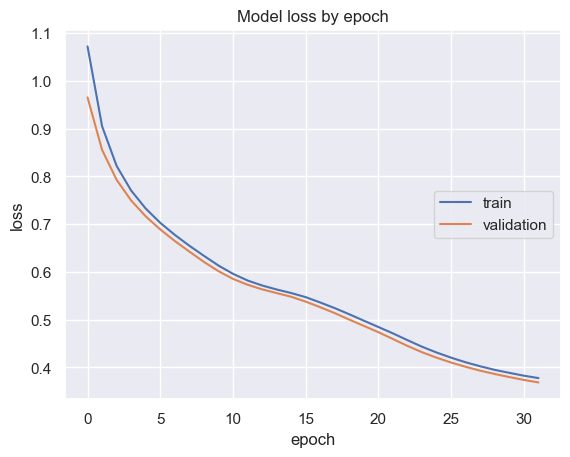

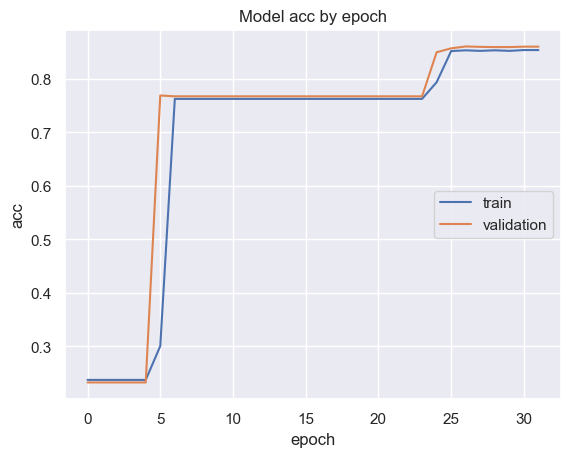

In [22]:
print ("-----------------------------------------------------------------------------")
print ("# ---- ( modelisation : Deep Learning ) ----------#")

# Dans la suite nous allons tester plusieurs modéles deep learning afin de choisir le best
##########################################################################################


# Création des couches de type Dense
####################################
inputs = Input(shape = (df_X.shape[1]), name = "Input")

dense1 = Dense(units = 100, activation = "sigmoid", name = "Dense_1")
dense2 = Dense(units = 50, activation = "sigmoid", name = "Dense_2")
dense3 = Dense(units = 10, activation = "sigmoid", name = "Dense_3")
dense4 = Dense(units = 5, activation = "sigmoid", name = "Dense_4")
dense5 = Dense(units = 2, activation = "sigmoid", name = "Dense_5")

x=dense1(inputs)
x=dense2(x)
x=dense3(x)
x=dense4(x)
outputs=dense5(x)

model = Model(inputs = inputs, outputs = outputs)
model.summary()



# Définir la Loss function
##########################
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = "adam",
              metrics = ["acc"])

# Entrainement de modèle
########################
history = model.fit(X_train_scaled,y_train,epochs=32,batch_size=256,validation_split=0.3)
 

# Test de modèle
################
test_pred = model.predict(X_test_scaled)
y_test_class = y_test
y_pred_class = np.argmax(test_pred,axis=1)


# On évalue le niveau de précision de notre prédiction
######################################################
print("Précision de la prédiction:", accuracy_score(y_test, y_pred_class)*100, '%')
print(classification_report(y_test_class,y_pred_class))
pd.crosstab(y_test_class, y_pred_class, rownames=['Classe réelle'], colnames=['Classe prédite'])



# Les plots de precision
########################
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')
plt.show()

